## 1. Module import

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 2. Data

In [57]:
df = pd.read_csv('../data/tfidf_output_cleaned.csv',encoding='latin1')
df.head()



,Label,Message,imp_feature
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


### Split data into 2 parts to train and test

In [58]:
x = df.iloc[: , -1]
y = df.iloc[: , 0]
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
X_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)
# Convert a pandas Series to a DataFrame
X_train_series = pd.Series(X_train)
X_train_df = X_train_series.to_frame()


# Tạo RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Áp dụng oversampling cho dữ liệu huấn luyện
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_df, y_train)
X_train_resampled = X_train_resampled.squeeze()
#X_train_resampled,  y_train_resampled


## 3.Model

Precision :  0.8875739644970414
Recall :  0.8522727272727273
Accuracy Score :  0.9651162790697675
F1 Score :  0.8695652173913043

 [[1095   19]
 [  26  150]]



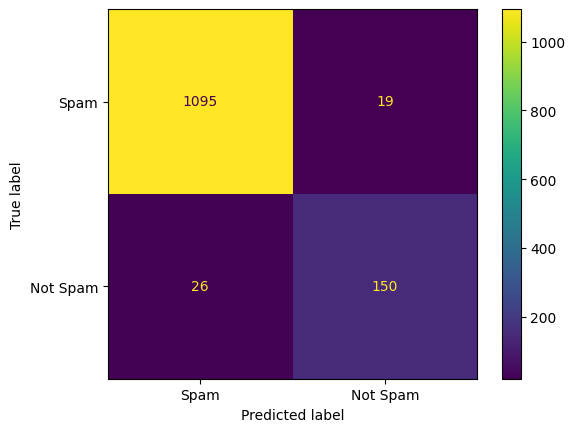

In [59]:

from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(X_train_resampled)


xgb = XGBClassifier().fit(x_train, y_train_resampled)

x_test = tfidf.transform(x_test)
y_pred_xgb = xgb.predict(x_test)


from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,ConfusionMatrixDisplay,confusion_matrix
def perform(y_pred):
    print("Precision : ", precision_score(y_test, y_pred))
    print("Recall : ", recall_score(y_test, y_pred))
    print("Accuracy Score : ", accuracy_score(y_test, y_pred))
    print("F1 Score : ", f1_score(y_test, y_pred))
    print("\n", confusion_matrix(y_test, y_pred))
    print("")
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels=['Spam', 'Not Spam'] )
    cm_display.plot()
    plt.show()

perform(y_pred_xgb)



## 4. Hypermeter tunning

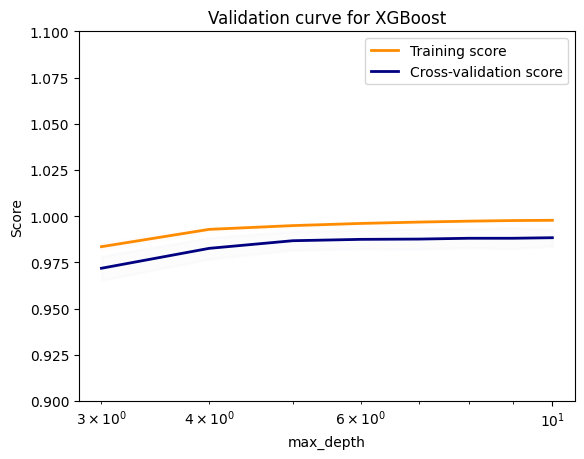

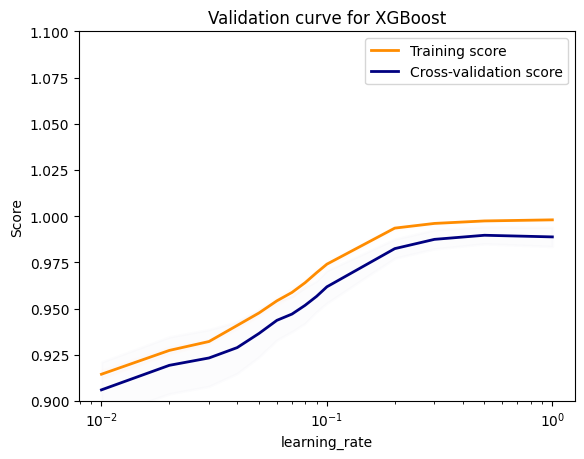

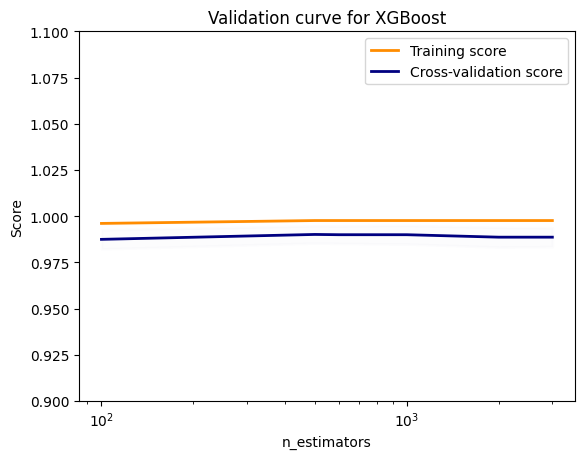

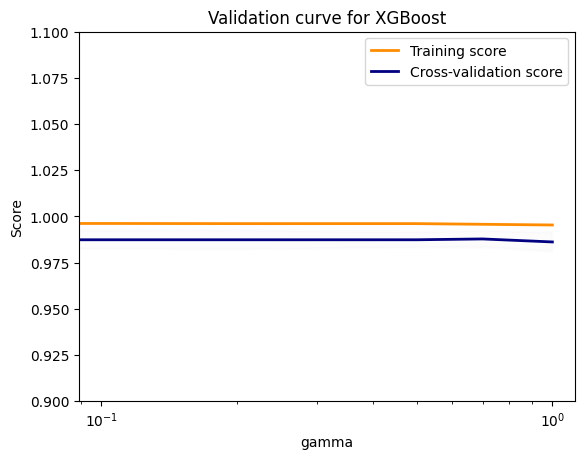

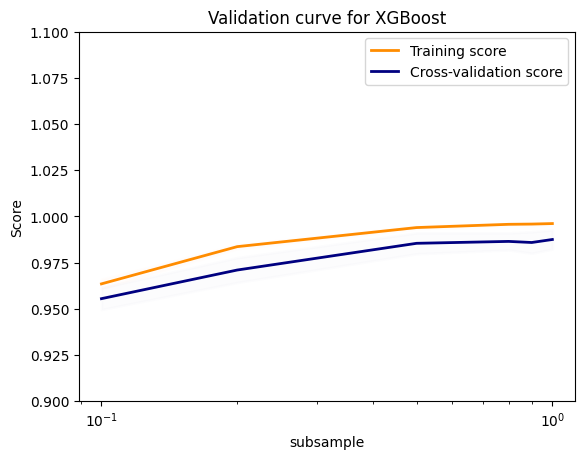

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

def plot_validation_curve(param_name,param_range):
    train_scores, test_scores = validation_curve(XGBClassifier(), x_train, y_train_resampled,
                                                param_name=param_name, param_range=param_range, cv=10, scoring='accuracy', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title('Validation curve for XGBoost')
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.ylim(0.9, 1.1)
    lw=2
    plt.semilogx(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        # train_scores_mean,
        # train_scores_mean,
        alpha=0.01,
        color="darkorange",
        lw=lw,
    )
    plt.semilogx(
        param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        # test_scores_mean,
        # test_scores_mean,
        alpha=0.01,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()
    
plot_validation_curve('max_depth',[3,4,5,6,7,8,9,10])
plot_validation_curve('learning_rate',[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.5,1])
plot_validation_curve('n_estimators',[100,500,600,900,1000,2000,3000])
plot_validation_curve('gamma',[0,0.1,0.2,0.5,0.7,1])
plot_validation_curve('subsample',[0.1,0.2,0.5,0.8,0.9,1])

In [29]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold


model = XGBClassifier()

learning_rates = [0.1,0.2,0.3,0.35,0.4,0.5]
max_depths = [5,6,7,8]
subsamples = [0.8,0.9,1]
# define grid search
grid = dict(learning_rate=learning_rates,max_depth=max_depths,subsample=subsamples)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=10, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train_resampled)
#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.990411 using {'learning_rate': 0.5, 'max_depth': 5, 'subsample': 1}
0.951461 (0.011071) with: {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}
0.950871 (0.008601) with: {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.9}
0.950575 (0.009270) with: {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1}
0.959724 (0.008369) with: {'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.8}
0.960461 (0.008967) with: {'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.9}
0.961789 (0.008811) with: {'learning_rate': 0.1, 'max_depth': 6, 'subsample': 1}
0.967542 (0.007226) with: {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.8}
0.968428 (0.007079) with: {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.9}
0.967838 (0.007739) with: {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 1}
0.971084 (0.007261) with: {'learning_rate': 0.1, 'max_depth': 8, 'subsample': 0.8}
0.971379 (0.008141) with: {'learning_rate': 0.1, 'max_depth': 8, 'subsample': 0.9}
0.972412 (0.00688

In [66]:
clf = XGBClassifier(learning_rate=0.5, max_depth=5,subsample=1)
clf.fit(x_train, y_train_resampled)

y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

train_acc = accuracy_score(y_train_resampled, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print("Train: ", train_acc)
print("Test: ", test_acc)

Train:  0.997789566755084
Test:  0.9643410852713178


# 4. Result

Precision :  0.877906976744186
Recall :  0.8579545454545454
Accuracy Score :  0.9643410852713178
F1 Score :  0.867816091954023

 [[1093   21]
 [  25  151]]



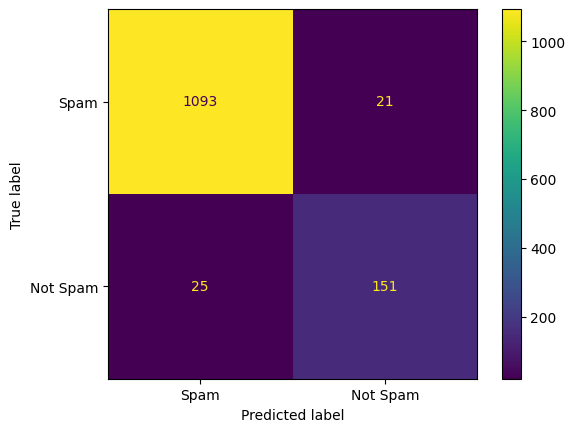

In [64]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay

def perform(y_pred):
    print("Precision : ", precision_score(y_test, y_pred))
    print("Recall : ", recall_score(y_test, y_pred))
    print("Accuracy Score : ", accuracy_score(y_test, y_pred))
    print("F1 Score : ", f1_score(y_test, y_pred))
    print("\n", confusion_matrix(y_test, y_pred))
    print("")
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels=['Spam', 'Not Spam'] )
    cm_display.plot()
    plt.show()

perform(y_pred_test)